In [1]:
import torch 
import numpy as np
import os
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from utils import *

In [2]:
NORMALIZE = True

CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DEVICE = torch.device(cuda_num if torch.cuda.is_available() else "cpu")
batch_size = 64

data_home = 'F:\\work'

if NORMALIZE:
    train_transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
    test_transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
else:
    train_transform = transforms.Compose([transforms.ToTensor()])
    test_transform = transforms.Compose([transforms.ToTensor()])
train_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=True, download=True, transform=train_transform)
test_set = torchvision.datasets.CIFAR10(root=os.path.join(data_home, 'dataset/CIFAR10'), train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = f.relu(self.conv1(x))
        x = f.max_pool2d(x, 2)
        x = f.relu(self.conv2(x))
        x = f.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = f.relu(self.fc1(x))
        x = f.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [11]:
# 测试模型在对每一个类的准确率
def test_per_class(model, c=None, sLoss=None, is_attack=False):
    model.eval();
    images_targets = {}
    epsilon = 0.3
    criterion = sLoss
    for special_index in range(10):
        count = 0
        correct = 0
        info_arr = torch.tensor([])
        info_arr = info_arr.to(DEVICE)

        for data, target in test_loader:
            data = data[target==special_index]
            target = target[target==special_index]
            if len(data) == 0:
                continue

            data, target = data.to(DEVICE), target.to(DEVICE)
            if is_attack:
                if c==None:
                    data, sign = my_fgsm(data, target, model, criterion, epsilon, DEVICE)
                else:
                    data, sign = my_fgsm(data, target, model, criterion, epsilon, DEVICE, c)
            output = model(data)

            # 计算熵
            tmp_output = torch.softmax(output, dim=1)
            info_entropy = -tmp_output * torch.log2(tmp_output)
            info_entropy = info_entropy.sum(dim=1)
            info_arr = torch.cat((info_arr, info_entropy))

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            count += len(data)
            print('\r {}'.format(count), end='')
        images_targets[special_index] = [count, correct/count, info_arr.detach().cpu().numpy()]
        print('\n {} correct on adv data: {}'.format(special_index,correct/count))
    return images_targets

def draw_result(res1, res2, title):
    res_normal = []
    res_cost_sensitive = []
    for index in range(10):
        res_normal.append(res1[index][1])
        res_cost_sensitive.append(res2[index][1])
    x = [0,1,2,3,4,5,6,7,8,9]
    plt.plot(x, res_normal, 'ro-', label='adv')
    plt.plot(x, res_cost_sensitive,'bo-', label='adv_cost_sensitive')
    plt.xticks(x)
    plt.title('Protect label: '+title)
    plt.legend(loc="upper right")
    plt.xlabel('Class Label')
    plt.ylabel('Accuracy')

In [28]:
# 读取正常模型
model_normal = LeNet()
model_normal.load_state_dict(torch.load('../model/Lenet_CIFAR.pt'))

<All keys matched successfully>

# 读取正常经过对抗训练的模型

In [13]:
if NORMALIZE:
    model_path = '../model/LeNet_CIFAR_adv_e0.3.pt'
    
print("read: {}".format(model_path))
model_adv = LeNet()
model_adv.load_state_dict(torch.load(model_path))

read: ../model/LeNet_CIFAR_adv_e0.3.pt


<All keys matched successfully>

In [14]:
# 测试模型 受对抗攻击能力
result_adv = test_per_class(model_adv, sLoss=nn.CrossEntropyLoss(), is_attack=True)

 1000
 0 correct on adv data: 0.717
 1000
 1 correct on adv data: 0.748
 1000
 2 correct on adv data: 0.632
 1000
 3 correct on adv data: 0.411
 1000
 4 correct on adv data: 0.593
 1000
 5 correct on adv data: 0.58
 1000
 6 correct on adv data: 0.672
 1000
 7 correct on adv data: 0.577
 1000
 8 correct on adv data: 0.753
 1000
 9 correct on adv data: 0.777


# 读取CSA模型

In [22]:
protect_class = 1

# 读取模型
if NORMALIZE:
    model_path = '../model/LeNet_CIFAR_adv_cost_sensitive_1_e0.3.pt'
print('read model:{}'.format(model_path))
model_0 = LeNet()
model_0.load_state_dict(torch.load(model_path))

read model:../model/LeNet_CIFAR_adv_cost_sensitive_1_e0.3.pt


<All keys matched successfully>

In [23]:
C = get_cost_matric(0, 10)
C = C.to(DEVICE)
print('cost matrix:')
print(C)
result_cost_sensitive_0 = test_per_class(model_0, c=C, sLoss=Loss_cost_sensitive(), is_attack=True)

cost matrix:
tensor([[ 0., 10., 10., 10., 10., 10., 10., 10., 10., 10.],
        [10.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.],
        [10.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.]])
 1000
 0 correct on adv data: 0.676
 1000
 1 correct on adv data: 0.835
 1000
 2 correct on adv data: 0.679
 1000
 3 correct on adv data: 0.553
 1000
 4 correct on adv data: 0.746
 1000
 5 correct on adv data: 0.648
 1000
 6 correct on adv data: 0.791
 1000
 7 correct on adv data: 0.7
 1000
 8 correct on adv data: 0.813
 1000
 9 correct on adv data: 0.748


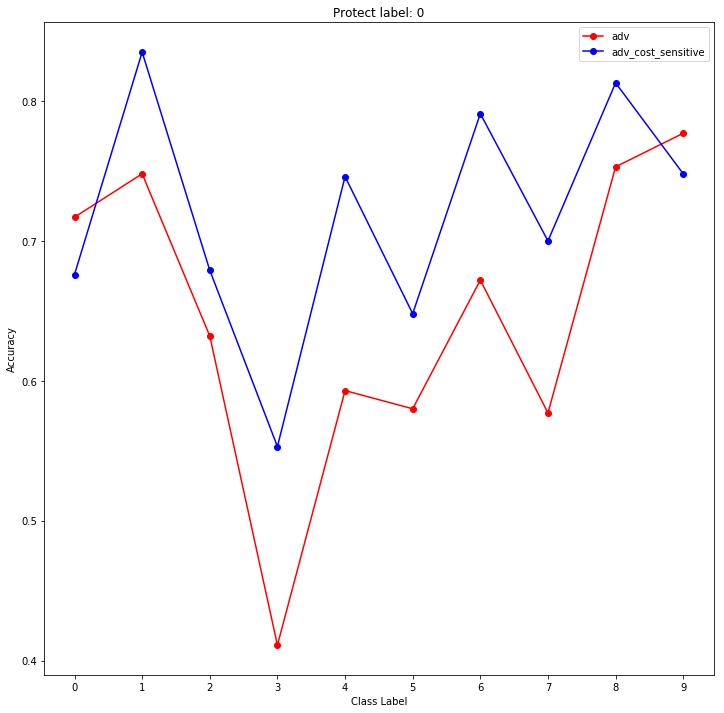

In [24]:
draw_result(result_adv, result_cost_sensitive_0, '0')

# 分析代价敏感的参数

In [16]:
import seaborn as sns

sns.set_palette('deep', desat=.6)
plt.rcParams['figure.figsize'] = (6.0, 6.0)

In [32]:
# 画出数据分布
def _draw_distributions(nums1, label1, nums2, label2, title):
    sns.distplot(nums1, label=label1, hist=False)
    sns.distplot(nums2, label=label2, hist=False)
    plt.title(title)
    plt.legend()
    
def _draw_distributions_2(nums1, label1, nums2, label2, nums3, label3, title):
    sns.distplot(nums1, label=label1, hist=False, color='Blue')
    sns.distplot(nums2, label=label2, hist=False, color='Red')
    sns.distplot(nums3, label=label3, hist=False, color='black')
    plt.title(title)
    plt.legend()
    
def draw_distributions(model1, label1, model2, label2):
    ncols = 2
    nrows = len(model1.state_dict())//2 + 1
    count = 1
    plt.rcParams['figure.figsize'] = (12.0, 12.0)
    plt.figure(figsize=(6 * ncols, 6 * nrows))
    
    for name in model1.state_dict():
        
        W1 = model1.state_dict()[name]
        W1 = W1.detach().cpu().numpy()
        W1 = W1.reshape(-1,)

        W2 = model2.state_dict()[name]
        W2 = W2.detach().cpu().numpy()
        W2 = W2.reshape(-1,)
        plt.subplot(nrows, ncols, count)
        _draw_distributions(W1, label1, W2, label2, name)
        count = count+1
        
def draw_distributions_2(model1, label1, model2, label2, model3, label3):
    ncols = 2
    nrows = len(model1.state_dict())//2 + 1
    count = 1
    plt.rcParams['figure.figsize'] = (12.0, 12.0)
    plt.figure(figsize=(6 * ncols, 6 * nrows))
    
    for name in model1.state_dict():
        
        W1 = model1.state_dict()[name]
        W1 = W1.detach().cpu().numpy()
        W1 = W1.reshape(-1,)

        W2 = model2.state_dict()[name]
        W2 = W2.detach().cpu().numpy()
        W2 = W2.reshape(-1,)
        
        W3 = model3.state_dict()[name]
        W3 = W3.detach().cpu().numpy()
        W3 = W3.reshape(-1,)
        
        plt.subplot(nrows, ncols, count)
        _draw_distributions_2(W1, label1, W2, label2, W3, label3, name)
        count = count+1

# 按顺序画
def _draw_step_by_step(nums1, label1, nums2, label2, title):
    x = [i for i in range(len(nums1))]
    sns.lineplot(x,nums1, label=label1)
    sns.lineplot(x,nums2, label=label2)
    plt.title(title)
    plt.legend()
    
def draw_step_by_step(model1, label1, model2, label2):
    ncols = 2
    nrows = len(model1.state_dict())//2 + 1
    count = 1
    plt.rcParams['figure.figsize'] = (12.0, 12.0)
    plt.figure(figsize=(6 * ncols, 6 * nrows))
    
    for name in model1.state_dict():
        
        W1 = model1.state_dict()[name]
        W1 = W1.detach().cpu().numpy()
        W1 = W1.reshape(-1,)

        W2 = model2.state_dict()[name]
        W2 = W2.detach().cpu().numpy()
        W2 = W2.reshape(-1,)
        plt.subplot(nrows, ncols, count)
        _draw_step_by_step(W1, label1, W2, label2, name)
        count = count+1
        
# 求模型各层参数的范数
def get_model_norms(model1, label1, model2, label2):
    for name in model1.state_dict():
        W1 = model1.state_dict()[name]
        W1 = W1.detach().cpu().numpy()
        W1 = W1.reshape(-1,)

        W2 = model2.state_dict()[name]
        W2 = W2.detach().cpu().numpy()
        W2 = W2.reshape(-1,)
        
        print(name+'(norm 1):   {}({}),   {}({})'.format(np.linalg.norm(W1, ord=1),label1, np.linalg.norm(W2, ord=1), label2))
        print(name+'(norm 2):   {}({}),   {}({})'.format(np.linalg.norm(W1, ord=2),label1, np.linalg.norm(W2, ord=2), label2))

D:\software\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


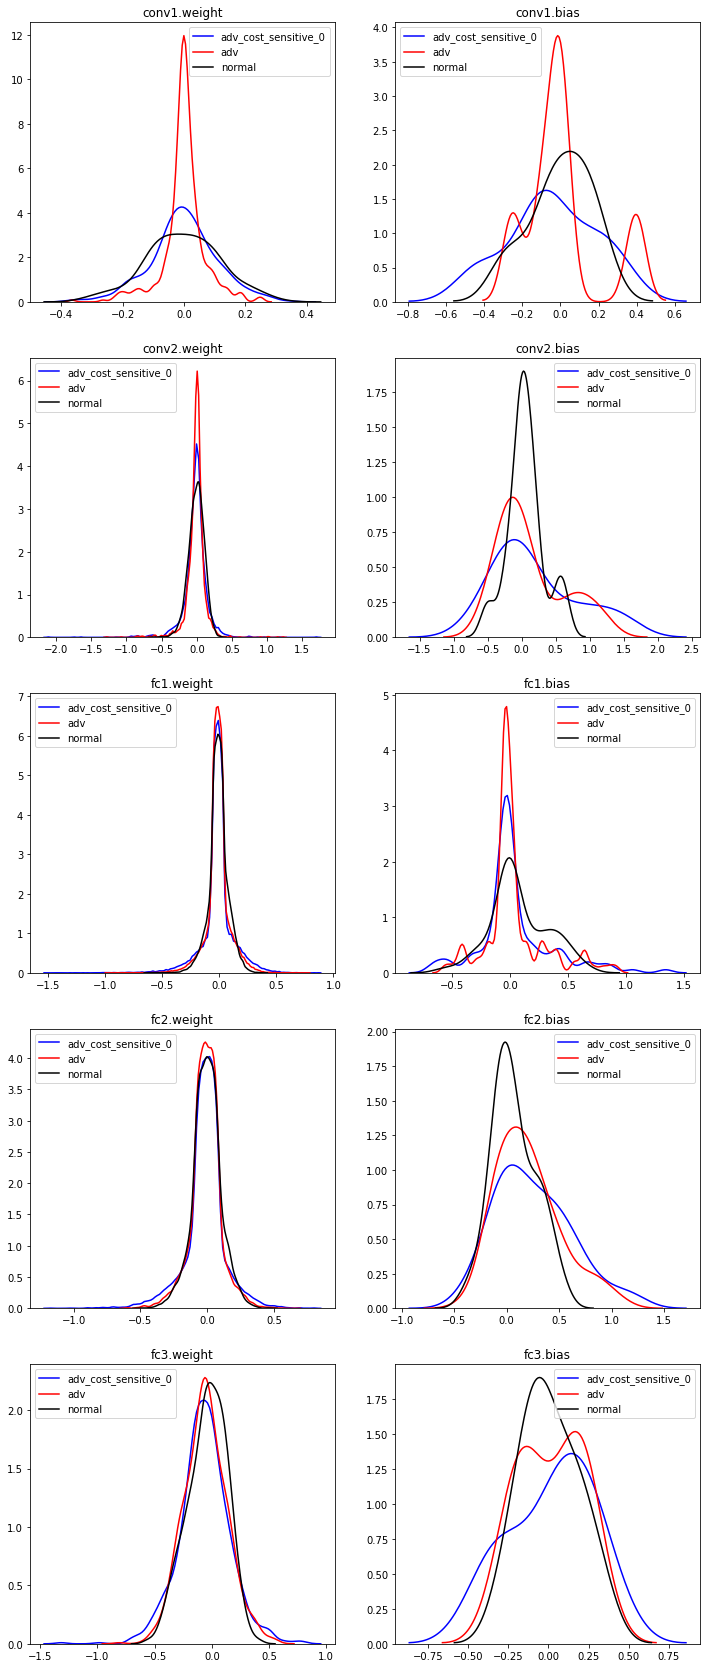

In [33]:
draw_distributions_2(model_0, 'adv_cost_sensitive_0', model_adv, 'adv', model_normal, 'normal')

In [21]:
torch.std(model_0.conv1.weight)

tensor(0.1077, grad_fn=<StdBackward0>)

In [26]:

model_path = '../model/Lenet_CIFAR.pt'
    
print("read: {}".format(model_path))
model = LeNet()
model.load_state_dict(torch.load(model_path))

read: ../model/Lenet_CIFAR.pt


<All keys matched successfully>

In [27]:
result_adv = test_per_class(model, sLoss=nn.CrossEntropyLoss(), is_attack=True)

 1000
 0 correct on adv data: 0.018
 1000
 1 correct on adv data: 0.0
 1000
 2 correct on adv data: 0.003
 1000
 3 correct on adv data: 0.001
 1000
 4 correct on adv data: 0.004
 1000
 5 correct on adv data: 0.0
 1000
 6 correct on adv data: 0.005
 1000
 7 correct on adv data: 0.011
 1000
 8 correct on adv data: 0.001
 1000
 9 correct on adv data: 0.005
